In [ ]:
!pip install pandas
!pip install numpy
!pip install statsmodels
!pip install seaborn
!pip install matplotlib
!pip install sklearn
!pip install lightgbm
!pip install scikit-learn

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

# gradient boosting 
from lightgbm import LGBMRegressor

In [4]:

# Read data
df_raw = pd.read_csv('../data/raw/bike_sharing_train.csv')
test = pd.read_csv('../data/raw/bike_sharing_test.csv')

In [5]:
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   datetime    10886 non-null  object 
 1   season      10886 non-null  int64  
 2   holiday     10886 non-null  int64  
 3   workingday  10886 non-null  int64  
 4   weather     10886 non-null  int64  
 5   temp        10886 non-null  float64
 6   atemp       10886 non-null  float64
 7   humidity    10886 non-null  int64  
 8   windspeed   10886 non-null  float64
 9   casual      10886 non-null  int64  
 10  registered  10886 non-null  int64  
 11  count       10886 non-null  int64  
dtypes: float64(3), int64(8), object(1)
memory usage: 1020.7+ KB


In [6]:
df_raw.sample(10)

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
10008,2012-11-02 09:00:00,4,0,1,1,13.94,17.425,53,7.0015,27,355,382
7233,2012-04-19 18:00:00,2,0,1,1,24.60,31.060,43,6.0032,99,677,776
9177,2012-09-05 18:00:00,3,0,1,1,31.16,37.120,75,12.9980,82,757,839
6568,2012-03-10 22:00:00,1,0,0,1,10.66,12.880,44,11.0014,19,81,100
9896,2012-10-16 17:00:00,4,0,1,1,21.32,25.000,39,12.9980,104,839,943
5377,2011-12-18 03:00:00,4,0,0,1,9.02,10.605,55,15.0013,2,16,18
10305,2012-11-14 19:00:00,4,0,1,1,12.30,15.150,52,11.0014,28,368,396
8126,2012-06-18 23:00:00,2,0,1,3,24.60,28.790,78,12.9980,17,57,74
2611,2011-06-16 17:00:00,2,0,1,2,26.24,29.545,78,7.0015,42,230,272
4555,2011-11-02 21:00:00,4,0,1,1,15.58,19.695,71,8.9981,13,155,168


In [7]:
# Cambio tipo de datos

df_interim = df_raw.copy()

df_interim['datetime'] = pd.to_datetime(df_interim['datetime'])

In [8]:
# Seteo tipo de datos fecha hora para trabajar con series de tiempo

df_interim = df_interim.set_index(df_interim['datetime'])

In [9]:
df_interim['hour'] = df_interim.index.hour
df_interim['day'] = df_interim.index.day
df_interim['month'] = df_interim.index.month

In [10]:
# borro variables
df_interim = df_interim.drop(['datetime', 'casual', 'registered'], axis=1)

In [11]:
df_interim.head(5)

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,count,hour,day,month
datetime,,,,,,,,,,,,
2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,16,0,1,1
2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,40,1,1,1
2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,32,2,1,1
2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,13,3,1,1
2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,1,4,1,1


In [12]:
df = df_interim.copy()

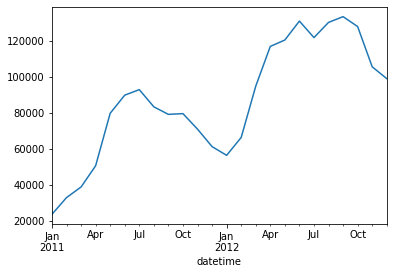

In [13]:
# Cantidad de operaciones por mes
# para eso agregamos con resample para cada mes ('M')

df['count'].resample('M').sum().plot()
plt.show()

In [14]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
season,10886.0,2.506614,1.116174,1.00,2.0000,3.000,4.0000,4.0000
holiday,10886.0,0.028569,0.166599,0.00,0.0000,0.000,0.0000,1.0000
workingday,10886.0,0.680875,0.466159,0.00,0.0000,1.000,1.0000,1.0000
weather,10886.0,1.418427,0.633839,1.00,1.0000,1.000,2.0000,4.0000
temp,10886.0,20.230860,7.791590,0.82,13.9400,20.500,26.2400,41.0000
atemp,10886.0,23.655084,8.474601,0.76,16.6650,24.240,31.0600,45.4550
humidity,10886.0,61.886460,19.245033,0.00,47.0000,62.000,77.0000,100.0000
windspeed,10886.0,12.799395,8.164537,0.00,7.0015,12.998,16.9979,56.9969
count,10886.0,191.574132,181.144454,1.00,42.0000,145.000,284.0000,977.0000
hour,10886.0,11.541613,6.915838,0.00,6.0000,12.000,18.0000,23.0000


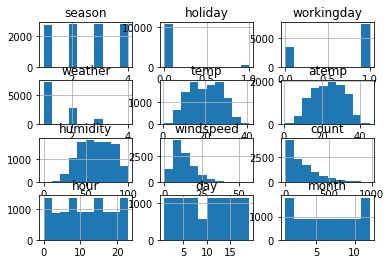

In [15]:
df.hist()
plt.show()
# la unidad mínima de nuestra serie de tiempo : hora

In [16]:
# Temporalidad

res = seasonal_decompose(df['count'].values, period=24) # period=24 porque la unidad mínima de los datos es la hora

res_observed = res.observed
res_trend = res.trend
res_seasonal = res.seasonal
res_residual = res.resid

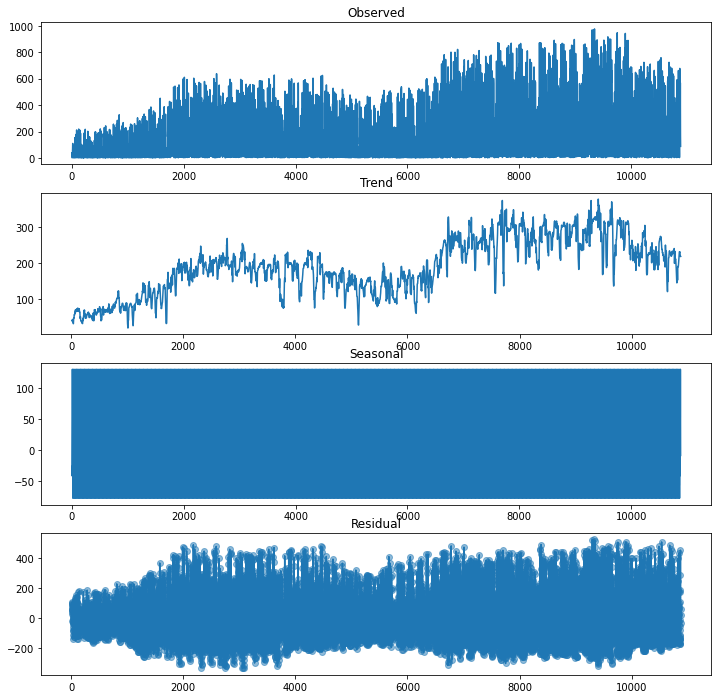

In [17]:
fig,ax = plt.subplots(4, figsize=(12,12))

ax[0].set_title('Observed')
ax[0].plot(res_observed)

ax[1].set_title('Trend')
ax[1].plot(res_trend)

ax[2].set_title('Seasonal')
ax[2].plot(res_seasonal)

ax[3].set_title('Residual')
ax[3].plot(res_residual)
ax[3].scatter(y=res_residual, x=range(len(res_residual)), alpha=0.5)

plt.show()

In [18]:
res = seasonal_decompose(df['count'].values[-200:], period=24) 
# period=24 porque la unidad mínima de los datos es la hora
# las últimas 200 observaciones


res_observed = res.observed
res_trend = res.trend
res_seasonal = res.seasonal
res_residual = res.resid

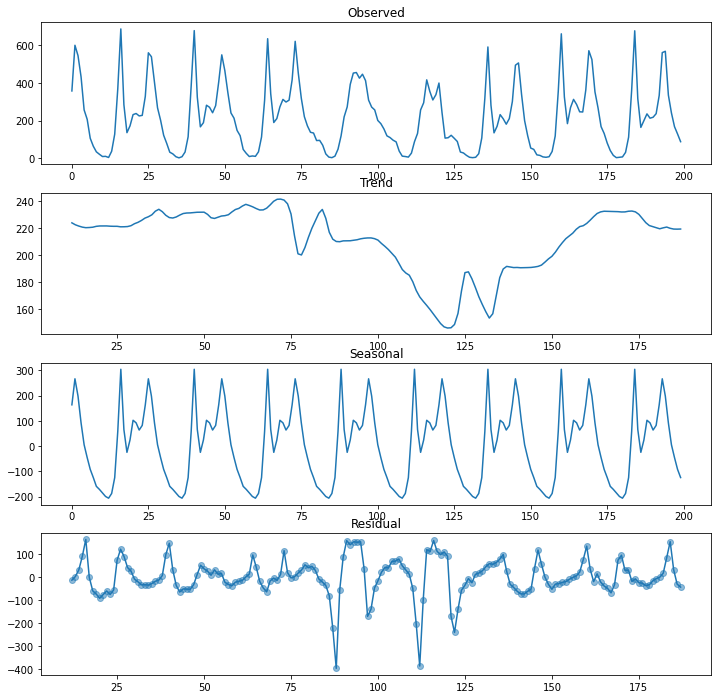

In [19]:
fig,ax = plt.subplots(4, figsize=(12,12))

ax[0].set_title('Observed')
ax[0].plot(res_observed)

ax[1].set_title('Trend')
ax[1].plot(res_trend)

ax[2].set_title('Seasonal')
ax[2].plot(res_seasonal)

ax[3].set_title('Residual')
ax[3].plot(res_residual)
ax[3].scatter(y=res_residual, x=range(len(res_residual)), alpha=0.5)

plt.show()

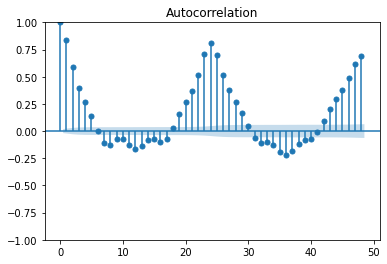

In [20]:
# Autocorrelación

plot_acf(df['count'].values, lags=48)
plt.show()

# la correlación entre la hora de un día y la del otro no es perfecta pero es alta
# punto 24 es la misma hora de otro día --> es alto pero no es 1, entre día y día patrón se repite pero no exacto
# parece que hay un patrón de horas
# si el seasonal se repite lo podemos usar como una variable de predicción

In [21]:
X = df.drop('count', axis=1)
y = df['count']

horizon = 168 #cantidad de horas en una semana

X_train, X_test = X.iloc[:-horizon,:], X.iloc[-horizon:,:] 
# X_train toma desde 0 hasta el total - 168, nos queda una semana de test
# X_test toma los últimos 168

y_train, y_test = y.iloc[:-horizon], y.iloc[-horizon:]

In [22]:
model = LGBMRegressor(random_state=123)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

In [23]:
mae = np.round(mean_absolute_error(y_test, y_pred), 1)
rmse = np.round(np.sqrt(mean_squared_error(y_test, y_pred)), 1)
print(f"MAE:{mae}, RMSE:{rmse}")
# mensualmente aprox son 100 mil

MAE:53.8, RMSE:73.8


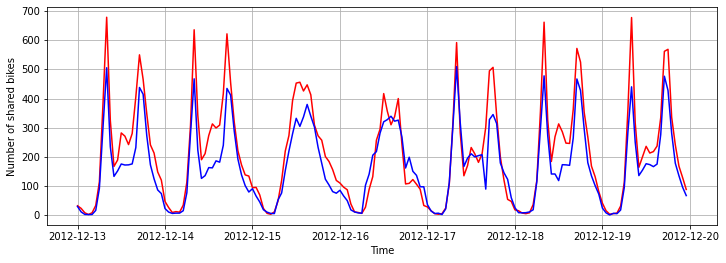

In [24]:
fig = plt.figure(figsize=(12,4))
plt.plot(y_test, color='Red')
plt.plot(pd.Series(y_pred, index=y_test.index), color='Blue')
plt.xlabel('Time')
plt.ylabel('Number of shared bikes')
plt.grid()
plt.show()

In [25]:
# Feature importance
df_var_imp = pd.DataFrame({'Var': model.feature_name_, 'Importance': model.feature_importances_}).sort_values(by='Importance', ascending=False)
df_var_imp

# la hora y el día son claves para el pronóstico de uso de bicicletas
# humedad y temperatura también

,Var,Importance
8,hour,752
9,day,401
6,humidity,392
4,temp,323
2,workingday,253
10,month,226
5,atemp,222
7,windspeed,190
0,season,102
3,weather,87


In [26]:
df['count_lag_week'] = df['count'].shift(24*7) 
# creamos variable lag de las horas de la semana anterior

df = df.dropna(how='any', axis=0)
# borramos las filas del ppio que van a tener na en esta nueva variable


In [27]:
X = df.drop('count', axis=1)
y = df['count']

horizon = 168 
#cantidad de horas en una semana

X_train, X_test = X.iloc[:-horizon,:], X.iloc[-horizon:,:] 
# X_train toma desde 0 hasta el total - 168, nos queda una semana de test
# X_test toma los últimos 168

y_train, y_test = y.iloc[:-horizon], y.iloc[-horizon:]

model = LGBMRegressor(random_state=123)

model.fit(X_train, y_train)

y_pred = model.predict(X_test)

mae = np.round(mean_absolute_error(y_test, y_pred),1)

rmse = np.round(mean_squared_error(y_test, y_pred, squared=False),1)

print(f'MAE: {mae}, RMSE: {rmse}')

MAE: 32.7, RMSE: 48.4


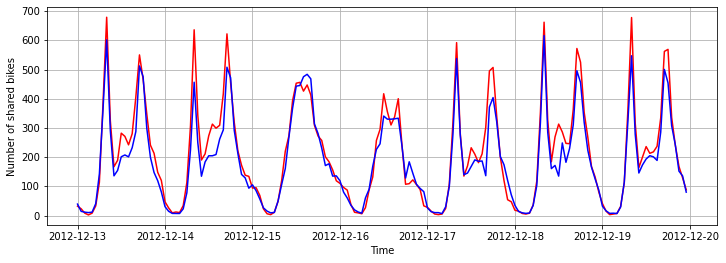

In [28]:
fig = plt.figure(figsize=(12,4))
plt.plot(y_test, color='Red')
plt.plot(pd.Series(y_pred, index=y_test.index), color='Blue')
plt.xlabel('Time')
plt.ylabel('Number of shared bikes')
plt.grid()
plt.show()

In [29]:
# Feature importance
df_var_imp = pd.DataFrame({'Var': model.feature_name_, 'Importance': model.feature_importances_}).sort_values(by='Importance', ascending=False)

df_var_imp

,Var,Importance
8,hour,703
11,count_lag_week,506
9,day,347
6,humidity,309
4,temp,296
2,workingday,237
5,atemp,170
10,month,154
7,windspeed,120
3,weather,70


In [31]:
df['count_lag_month'] = df['count'].shift(24*7*30) 
df = df.dropna(how='any', axis=0)

In [32]:
X = df.drop('count', axis=1)
y = df['count']

horizon = 168 #cantidad de horas en una semana

X_train, X_test = X.iloc[:-horizon,:], X.iloc[-horizon:,:] 
# X_train toma desde 0 hasta el total - 168, nos queda una semana de test
# X_test toma los últimos 168

y_train, y_test = y.iloc[:-horizon], y.iloc[-horizon:]

model = LGBMRegressor(random_state=123)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

mae = np.round(mean_absolute_error(y_test, y_pred),1)
rmse = np.round(mean_squared_error(y_test, y_pred, squared=False),1)

print(f'MAE: {mae}, RMSE: {rmse}')

MAE: 30.5, RMSE: 43.1


In [33]:
# Feature importance
# variable count_lag_week no ayudo a mejorar la predicción
df_var_imp = pd.DataFrame({'Var': model.feature_name_, 'Importance': model.feature_importances_}).sort_values(by='Importance', ascending=False)

df_var_imp

,Var,Importance
8,hour,735
11,count_lag_week,505
9,day,299
2,workingday,266
6,humidity,235
12,count_lag_month,218
4,temp,195
5,atemp,150
10,month,112
7,windspeed,106
